In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import os.path
import math
from xgboost import XGBClassifier
from sklearn.externals import joblib
import pandas as pd

n_bytes = 2**31
max_bytes = 2**31 - 1

class Time_Tracking():
    
    start_time = None
    
    def start_tracking(self):
        
        self.start_time = time.time()
    
    def stop_tracking(self):
        
        print("Time used:", round(((time.time() - self.start_time)/60),2), ' minutes')


def load_pickle(file_path):
    
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    
    return pickle.loads(bytes_in)

In [2]:
model = joblib.load("xgb.pickle.dat")

train = load_pickle('train_df_after_preprocessing.pkl')
valid = load_pickle('valid_df_after_preprocessing.pkl')
test = load_pickle('test_df_after_preprocessing.pkl')

valid_click = valid['click']
valid_bidprice = valid['bidprice']
valid_payprice = valid['payprice']
valid_X = valid.drop(['click', 'bidprice', 'payprice'], axis = 1)

In [3]:
valid_ctr_prediction = model.predict_proba(valid_X)

# Exponential Bidding: bid_price = base_bid * e^(pCTR / avgCTR)

In [4]:
def EvaluateClick( bid_price, budget, valid_payprice, valid_click):
    
    auction = bid_price >= valid_payprice
    win_bid_ix = [ index for index,auc in enumerate(auction) if auc ]
    bid_spends = valid_payprice[win_bid_ix].values
    bid_clicks = valid_click[win_bid_ix].values

    budget = 6250000
    current_spend = sum(bid_spends)

    total_bids = len(bid_spends)

    for i in range(len(bid_spends)):

        current_spend -= bid_spends[total_bids-i-1]

        if current_spend <= budget:
            break

    final_win_bid_ix = win_bid_ix[:(total_bids - i -1)]
    bid_spends = sum(valid_payprice[final_win_bid_ix].values)
    bid_clicks = sum(valid_click[final_win_bid_ix].values)
    
    print('clicks:', bid_clicks, 'impressions:', len(final_win_bid_ix), 'spend:', bid_spends)

    return bid_clicks

clicks: 126 impressions: 160365 spend: 6142773
clicks: 126 impressions: 160931 spend: 6179921
clicks: 127 impressions: 161334 spend: 6207505
clicks: 127 impressions: 161688 spend: 6231225
clicks: 127 impressions: 161940 spend: 6249997
clicks: 126 impressions: 161671 spend: 6249994
clicks: 125 impressions: 161338 spend: 6249993
clicks: 125 impressions: 161002 spend: 6249989
clicks: 124 impressions: 160733 spend: 6249965
clicks: 123 impressions: 160368 spend: 6249981
best constant: 43.2


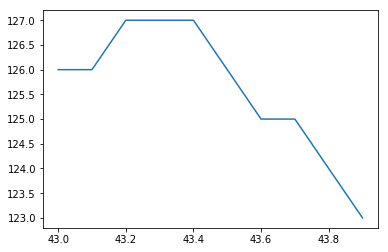

In [5]:
# search the best base_price
base_prices = np.arange(43,44,0.1)
clicks = []
budget = 6250000
avgCTR=0.738

for base in base_prices:
    
    valid_pctr = valid_ctr_prediction[:,1]
    bid_price = [ int(base * np.exp(pCTR/avgCTR)) for pCTR in valid_pctr ]
    c = EvaluateClick( bid_price, budget, valid_payprice, valid_click);
    clicks.append(c)

    
plt.figure()
plt.plot(base_prices, clicks)
print('best constant:', base_prices[clicks.index(max(clicks))])

In [6]:
base = base_prices[clicks.index(max(clicks))]

bid_price = [ int(base * np.exp(pCTR/avgCTR)) for pCTR in valid_pctr ]
EvaluateClick( bid_price, budget , valid_payprice, valid_click)

clicks: 127 impressions: 161334 spend: 6207505


127

In [7]:
### prediction
base = base_prices[clicks.index(max(clicks))]

test_prediction = model.predict_proba(test)[:,1]
bid_price = [ int(base * np.exp(pCTR/avgCTR)) for pCTR in test_prediction ]

submission = pd.read_csv('Group_xx.csv')
submission['bidprice'] = bid_price
submission.to_csv('XGB_with_Exponential.csv')